In [1]:
from openptv_python.calibration import Calibration, read_calibration
from openptv_python.parameters import MultimediaPar
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import math

def multimed_r_nlay(cal, mm, pos):
    it = 0
    n_iter = 40
    mmf = 1.0
    
    # Extracting values from the pos vector
    X, Y, Z = pos
    
    # Calculate r and initialize rq
    r = math.sqrt((X - cal.ext_par.x0)**2 + (Y - cal.ext_par.y0)**2)
    rq = r
    
    # Calculate zout
    zout = Z + sum(mm.d[i] for i in range(1, mm.nlay))
    
    while True:
        # Calculate beta1
        beta1 = math.atan(rq / (cal.ext_par.z0 - Z))
        
        # Calculate beta2 for each layer
        beta2 = [math.asin(math.sin(beta1) * mm.n1 / mm.n2[i]) for i in range(mm.nlay)]
        
        # Calculate beta3
        beta3 = math.asin(math.sin(beta1) * mm.n1 / mm.n3)
        
        # Calculate rbeta
        rbeta = (cal.ext_par.z0 - mm.d[0]) * math.tan(beta1) - zout * math.tan(beta3)
        rbeta += sum(mm.d[i] * math.tan(beta2[i]) for i in range(mm.nlay))
        
        # Calculate rdiff and update rq
        rdiff = r - rbeta
        rq += rdiff
        
        # Increment iteration counter
        it += 1
        
        # Check convergence criteria
        if not (-0.001 <= rdiff <= 0.001) or it >= n_iter:
            break
    
    if it >= n_iter:
        print(f"multimed_r_nlay stopped after {n_iter} iterations")
        return 1.0
    
    return rq / r if r != 0 else 1.0


In [3]:
pos = np.zeros(3, dtype=np.float64)
mm = MultimediaPar(n1=1.0, n2=[1.46], n3=1.33, d=[10.0])
cal = Calibration()
cal.ext_par.z0 = 100.0

In [4]:
rdiff = multimed_r_nlay(cal, mm, pos)
print(rdiff)

multimed_r_nlay stopped after 40 iterations
1.0


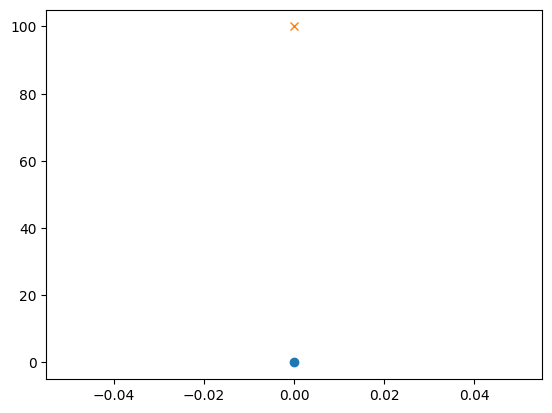

In [5]:
plt.figure()
plt.plot(pos[0], pos[2], 'o')
plt.plot(cal.ext_par.x0, cal.ext_par.z0, 'x')